In [ ]:
#default_exp data.block

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc

In [ ]:
#For examples, so not exported
from local.vision.core import *
from local.vision.augment import *

# Data block

> High level API to quickly get your data in a `DataBunch`

## General API

In [ ]:
#export
from inspect import isfunction,ismethod

In [ ]:
#export
def _merge_tfms(*tfms):
    "Group the `tfms` in a single list, removing duplicates (from the same class) and instantiating"
    g = groupby(concat(*tfms), lambda o:
        o if isinstance(o, type) else o.__qualname__ if (isfunction(o) or ismethod(o)) else o.__class__)
    return L(v[-1] for k,v in g.items()).map(instantiate)

In [ ]:
#hide
tfms = _merge_tfms([Categorize, MultiCategorize, Categorize(['dog', 'cat'])], Categorize(['a', 'b']))
#If there are several instantiated versions, the last one is kept.
test_eq(len(tfms), 2)
test_eq(tfms[1].__class__, MultiCategorize)
test_eq(tfms[0].__class__, Categorize)
test_eq(tfms[0].vocab, ['a', 'b'])

tfms = _merge_tfms([PILImage.create, PILImage.show])
#Check methods are properly separated
test_eq(len(tfms), 2)
tfms = _merge_tfms([show_image, set_trace])
#Check functions are properly separated
test_eq(len(tfms), 2)

In [ ]:
#export
@docs
@funcs_kwargs
class DataBlock():
    "Generic container to quickly build `DataSource` and `DataBunch`"
    get_x=get_items=splitter=get_y = None
    _methods = 'get_items splitter get_y get_x'.split()
    def __init__(self, ts=None, **kwargs):
        types = L(getattr(self,'types',(float,float)) if ts is None else ts)
        self.default_type_tfms = types.map(
            lambda t: L(getattr(t,'create',None)) + L(getattr(t,'default_type_tfms',None)))
        self.default_ds_tfms = _merge_tfms(ToTensor, *types.attrgot('default_ds_tfms', L()))
        self.default_dl_tfms = _merge_tfms(Cuda    , *types.attrgot('default_dl_tfms', L()))

    def datasource(self, source, type_tfms=None):
        self.source = source
        items = (self.get_items or noop)(source)
        if isinstance(items,tuple):
            items = L(items).zip()
            labellers = [itemgetter(i) for i in range_of(self.default_type_tfms)]
        else: labellers = [noop] * len(self.default_type_tfms)
        splits = (self.splitter or noop)(items)
        if self.get_x: labellers[0] = self.get_x
        if self.get_y: labellers[1] = self.get_y
        if type_tfms is None: type_tfms = [L() for t in self.default_type_tfms]
        type_tfms = L([self.default_type_tfms, type_tfms, labellers]).map_zip(
            lambda tt,tfm,l: L(l) + _merge_tfms(tt, tfm))
        return DataSource(items, tfms=type_tfms, filts=splits)

    def databunch(self, source, type_tfms=None, ds_tfms=None, dl_tfms=None, bs=16, **kwargs):
        dsrc = self.datasource(source, type_tfms=type_tfms)
        ds_tfms = _merge_tfms(self.default_ds_tfms, ds_tfms)
        dl_tfms = _merge_tfms(self.default_dl_tfms, dl_tfms)
        return dsrc.databunch(bs=bs, after_item=ds_tfms, after_batch=dl_tfms, **kwargs)

    _docs = dict(datasource="Create a `Datasource` from `source` with `tfms` and `tuple_tfms`",
                 databunch="Create a `DataBunch` from `source` with `tfms`")

To build a `DataBlock` you need to give the library four things: the types of your input/labels then at least two functions: `__getitem__` and `splitter`. You may also need to include `get_x` and `get_y`.

Once those are provided, you automatically get a `DataSource` or a `DataBunch`:

In [ ]:
show_doc(DataBlock.datasource)

<h4 id="DataBlock.datasource" class="doc_header"><code>DataBlock.datasource</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.datasource</code>(**`source`**, **`type_tfms`**=*`None`*)

Create a `Datasource` from `source` with `tfms` and `tuple_tfms`

In [ ]:
show_doc(DataBlock.databunch)

<h4 id="DataBlock.databunch" class="doc_header"><code>DataBlock.databunch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>DataBlock.databunch</code>(**`source`**, **`type_tfms`**=*`None`*, **`ds_tfms`**=*`None`*, **`dl_tfms`**=*`None`*, **`bs`**=*`16`*, **\*\*`kwargs`**)

Create a [`DataBunch`](/data.core.html#DataBunch) from `source` with `tfms`

## Examples

### Classification - MNIST

In [ ]:
class MNIST(DataBlock):
    types = PILImageBW,Category
    def get_items(self, source): return get_image_files(Path(source))
    def splitter (self, items ): return GrandparentSplitter()(items)
    def get_y    (self, item  ): return parent_label(item)

In [ ]:
mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY))
#TODO: access vocab
# mnist = MNIST().datasource(untar_data(URLs.MNIST_TINY), type_tfms=[None, Categorize(['1', '2', '3', '4'])])
#test_eq(mnist.vocab, ['1', '2', '3', '4'])

In [ ]:
mnist.train[0]

(<local.vision.core.PILImageBW image mode=L size=28x28 at 0x7FAEB8D0FD68>, 0)

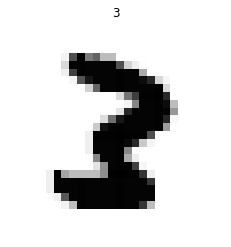

In [ ]:
show_at(mnist.train, 0, cmap='Greys');

In [ ]:
mnist = DataBlock(ts=(PILImageBW, Category), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

In [ ]:
dbunch = mnist.databunch(untar_data(URLs.MNIST_TINY))

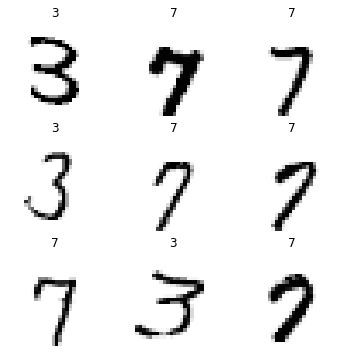

In [ ]:
dbunch.show_batch(max_n=9, figsize=(6,6))

### Pets

In [ ]:
pets = DataBlock(ts=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

dbunch = pets.databunch(untar_data(URLs.PETS)/"images", ds_tfms=Resize(128),
                        dl_tfms=aug_transforms())

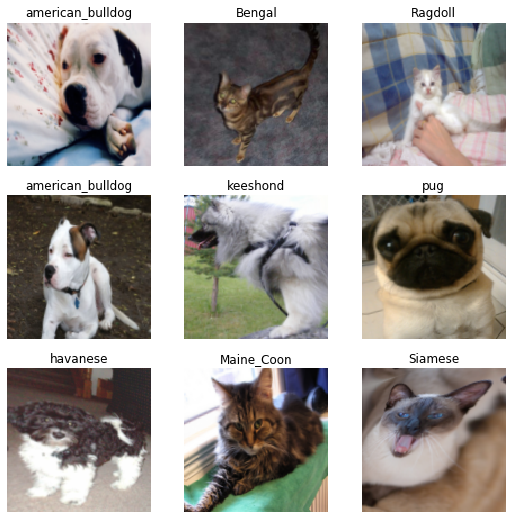

In [ ]:
dbunch.show_batch(max_n=9)

### Multi-label classification

In [ ]:
#export
MultiCategory.default_type_tfms = OneHotEncode

In [ ]:
planet_source = untar_data(URLs.PLANET_TINY)
df = pd.read_csv(planet_source/"labels.csv")

In [ ]:
planet = DataBlock(ts=(PILImage, MultiCategory),
                   get_x=lambda x:planet_source/"train"/f'{x[0]}.jpg',
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1].split(' '))

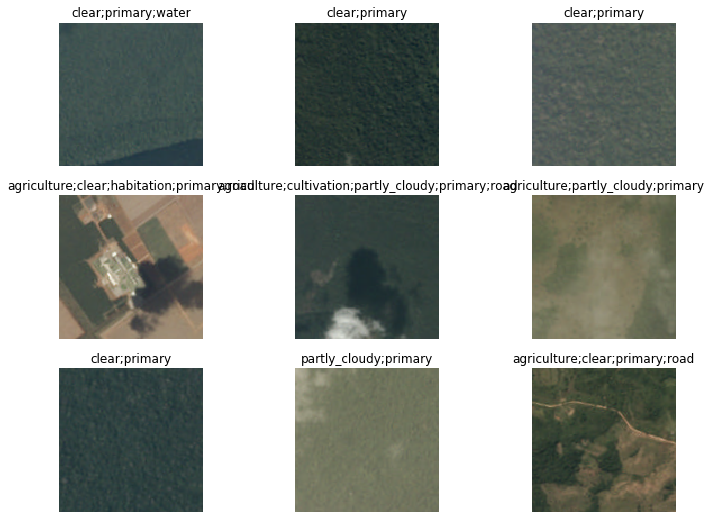

In [ ]:
dbunch = planet.databunch(df.values,
         dl_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))
dbunch.show_batch(max_n=9, figsize=(12,9))

In [ ]:
def _planet_items(x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

planet = DataBlock(ts=(PILImage,MultiCategory),
                   get_items = _planet_items,
                   splitter = RandomSplitter())

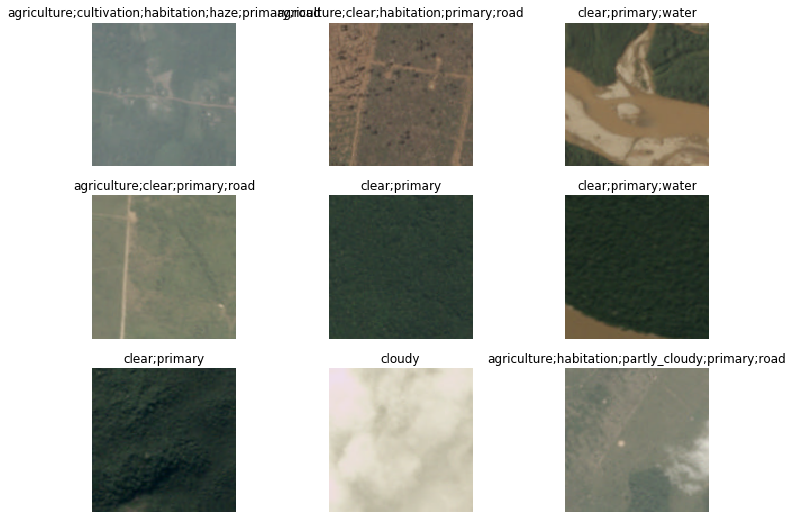

In [ ]:
dbunch = planet.databunch(df, dl_tfms=aug_transforms(
    flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))
dbunch.show_batch(max_n=9, figsize=(12,9))

In [ ]:
class PlanetDataBlock(DataBlock):
    types = PILImage,MultiCategory
    splitter = staticmethod(RandomSplitter())
    def get_items(self, x): return (
        f'{planet_source}/train/' + x.image_name + '.jpg', x.tags.str.split())

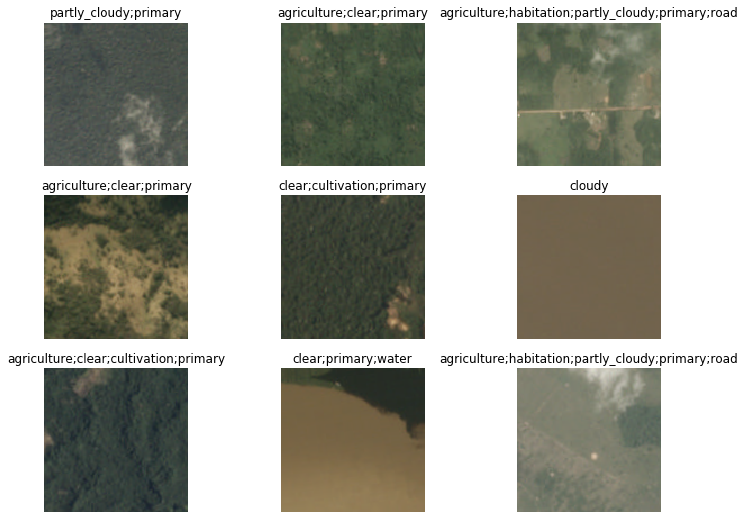

In [ ]:
planet = PlanetDataBlock()
dbunch = planet.databunch(df, dl_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))
dbunch.show_batch(max_n=9, figsize=(12,9))

In [ ]:
planet = DataBlock(ts=(PILImage,MultiCategory),
                   get_x = lambda o:f'{planet_source}/train/'+o.image_name+'.jpg',
                   get_y = lambda o:o.tags.split(),
                   splitter = RandomSplitter())

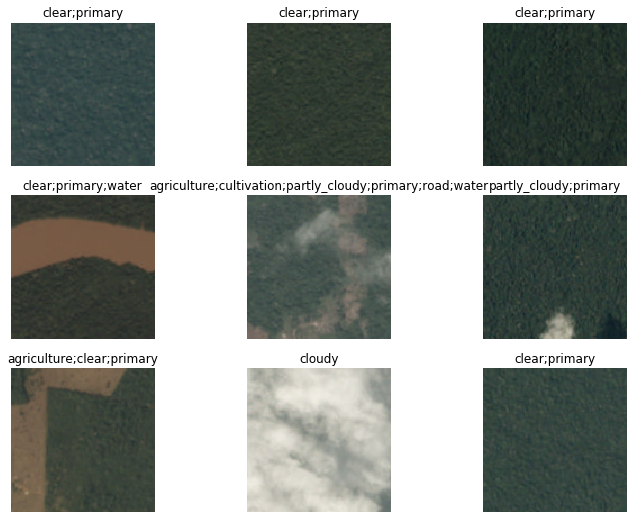

In [ ]:
dbunch = planet.databunch(df, dl_tfms=aug_transforms(
    flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))
dbunch.show_batch(max_n=9, figsize=(12,9))

### Segmentation

In [ ]:
camvid = DataBlock(ts=(PILImage, PILMask),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}')

In [ ]:
dbunch = camvid.databunch(untar_data(URLs.CAMVID_TINY)/"images", dl_tfms=aug_transforms())

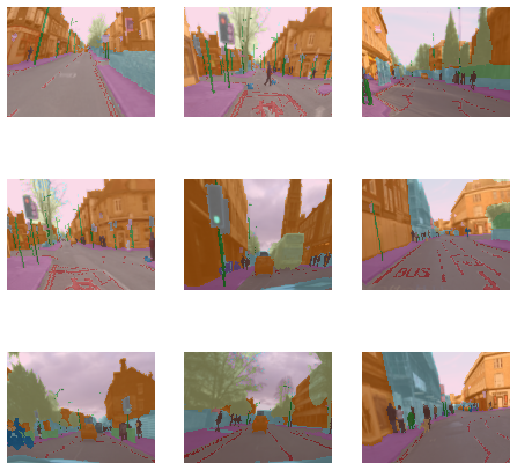

In [ ]:
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

### Points

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi_source/'centers.pkl', 'rb'))

biwi = DataBlock(ts=(PILImage, TensorPoint),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0))

In [ ]:
dbunch = biwi.databunch(biwi_source, dl_tfms=aug_transforms())

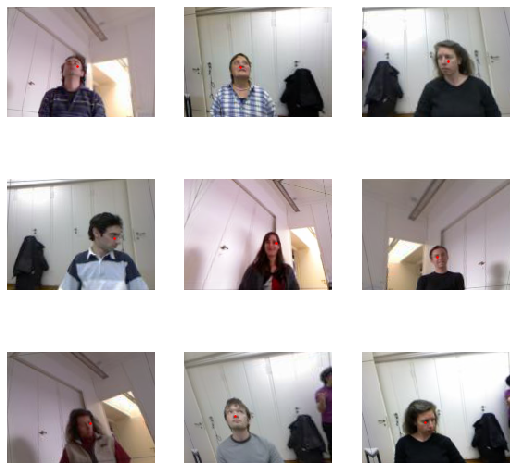

In [ ]:
dbunch.show_batch(max_n=9)

### Bounding boxes

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

coco = DataBlock(ts=(PILImage, BBox),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o: img2bbox[o.name])

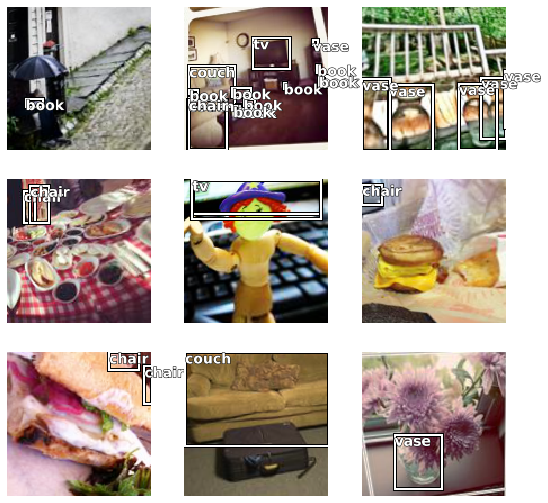

In [ ]:
dbunch = coco.databunch(coco_source, ds_tfms=Resize(128), dl_tfms=aug_transforms(), before_batch=bb_pad)
dbunch.show_batch(max_n=9)

### Language model TODO

### Text classification TODO

### Tabular data

In [ ]:
from local.tabular.core import *

In [ ]:
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)

In [ ]:
dbch = to.databunch()
dbch.show_batch()

,age,fnlwgt,education-num,workclass,education,marital-status,occupation,relationship,race,age_na,fnlwgt_na,education-num_na,salary
0,65.999998,261061.998346,14.0,Local-gov,Masters,Widowed,Prof-specialty,Not-in-family,White,False,False,False,<50k
1,30.000000,312766.996832,9.0,State-gov,HS-grad,Never-married,Sales,Unmarried,Black,False,False,False,<50k
2,27.000000,198258.000303,13.0,Private,Bachelors,Never-married,Sales,Own-child,White,False,False,False,<50k
3,31.000000,50648.998082,14.0,Local-gov,Masters,Never-married,Prof-specialty,Not-in-family,White,False,False,False,<50k
4,30.000000,339772.998299,9.0,Private,HS-grad,Never-married,Machine-op-inspct,Not-in-family,White,False,False,False,<50k
5,31.000000,288566.001373,13.0,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,False,False,False,>=50k
6,38.000000,127961.000129,10.0,Self-emp-not-inc,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,White,False,False,False,>=50k
7,33.000000,152350.999563,10.0,Local-gov,Some-college,Married-civ-spouse,Protective-serv,Husband,White,False,False,False,<50k
8,21.000001,415912.991457,10.0,?,Some-college,Never-married,?,Own-child,White,False,False,False,<50k
9,63.000001,159714.999257,6.0,Self-emp-not-inc,10th,Married-civ-spouse,Machine-op-inspct,Husband,White,False,False,False,<50k


## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 02_script.ipynb.
Converted 03_dataloader.ipynb.
Converted 04_transform.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 22_vision_learner.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.ipynb.